In [4]:
pip install optuna

In [5]:
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score, classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import xgboost as xgb

In [6]:
df = pd.read_csv('insurance_claims.csv')
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [7]:
print("Columns in the dataset:")
print(df.columns.tolist())

Columns in the dataset:
['months_as_customer', 'age', 'policy_number', 'policy_bind_date', 'policy_state', 'policy_csl', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'capital-gains', 'capital-loss', 'incident_date', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'property_damage', 'bodily_injuries', 'witnesses', 'police_report_available', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make', 'auto_model', 'auto_year', 'fraud_reported', '_c39']


# Checking for missing values, duplicates and imbalance

In [8]:
# Check if missing values exist in columns
missing_values_count = df.isnull().sum()

print(missing_values_count)

months_as_customer                0
age                               0
policy_number                     0
policy_bind_date                  0
policy_state                      0
policy_csl                        0
policy_deductable                 0
policy_annual_premium             0
umbrella_limit                    0
insured_zip                       0
insured_sex                       0
insured_education_level           0
insured_occupation                0
insured_hobbies                   0
insured_relationship              0
capital-gains                     0
capital-loss                      0
incident_date                     0
incident_type                     0
collision_type                    0
incident_severity                 0
authorities_contacted            91
incident_state                    0
incident_city                     0
incident_location                 0
incident_hour_of_the_day          0
number_of_vehicles_involved       0
property_damage             

In [9]:
duplicates = df[df['policy_number'].duplicated(keep=False)]  # Shows all duplicate entries
print(duplicates)

# There are NO duplicates

Empty DataFrame
Columns: [months_as_customer, age, policy_number, policy_bind_date, policy_state, policy_csl, policy_deductable, policy_annual_premium, umbrella_limit, insured_zip, insured_sex, insured_education_level, insured_occupation, insured_hobbies, insured_relationship, capital-gains, capital-loss, incident_date, incident_type, collision_type, incident_severity, authorities_contacted, incident_state, incident_city, incident_location, incident_hour_of_the_day, number_of_vehicles_involved, property_damage, bodily_injuries, witnesses, police_report_available, total_claim_amount, injury_claim, property_claim, vehicle_claim, auto_make, auto_model, auto_year, fraud_reported, _c39]
Index: []

[0 rows x 40 columns]


In [10]:
# Check the imbalance of dataset
fraud_distribution = df['fraud_reported'].value_counts()

print(fraud_distribution)

fraud_reported
N    753
Y    247
Name: count, dtype: int64


<ipython-input-11-e14467441f28>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


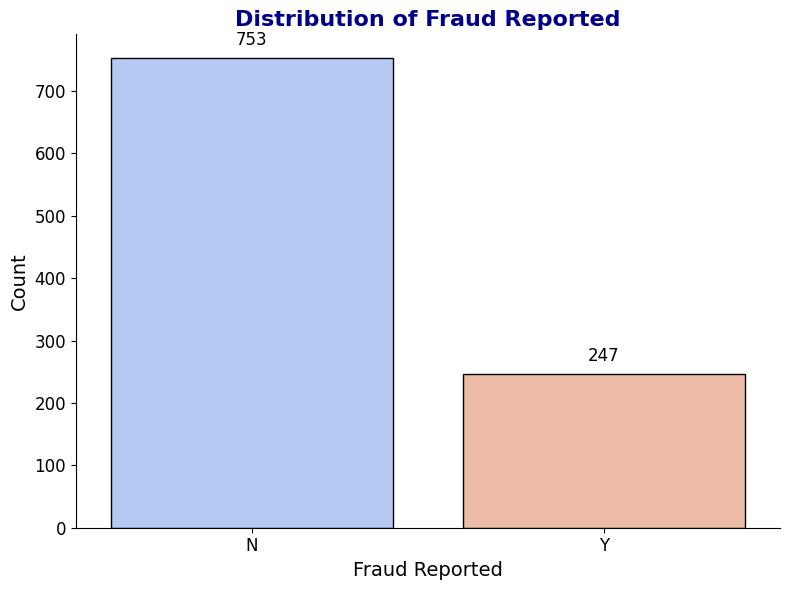

In [11]:
# Plot the distribution
# Create a figure with improved styling
plt.figure(figsize=(8, 6))
sns.barplot(
    x=fraud_distribution.index,
    y=fraud_distribution.values,
    palette="coolwarm",  # Adjust color palette
    edgecolor='black'  # Add border to bars
)

# Add annotations for values
for i, val in enumerate(fraud_distribution.values):
    plt.text(i, val + 20, str(val), ha='center', fontsize=12, color='black')

# Customizing the plot
plt.title('Distribution of Fraud Reported', fontsize=16, weight='bold', color='darkblue')
plt.xlabel('Fraud Reported', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine()  # Remove top and right borders for a cleaner look

# Show the plot
plt.tight_layout()
plt.show()

# splitting dataset for first part of research

In [12]:
# List of columns to extract
columns_to_extract = [
    "age", "months_as_customer", "witnesses", "number_of_vehicles_involved",
    "police_report_available", "incident_date", "incident_hour_of_the_day",
    "incident_type", "auto_model", "auto_year"
]

# Create a new dataset with the selected columns
new_df = df[columns_to_extract]

# Save the new dataset to a CSV file (optional)
new_df.to_csv("subset_dataset.csv", index=False)

# Display the first few rows of the new dataset
new_df.head()

,age,months_as_customer,witnesses,number_of_vehicles_involved,police_report_available,incident_date,incident_hour_of_the_day,incident_type,auto_model,auto_year
0,48,328,2,1,YES,2015-01-25,5,Single Vehicle Collision,92x,2004
1,42,228,0,1,?,2015-01-21,8,Vehicle Theft,E400,2007
2,29,134,3,3,NO,2015-02-22,7,Multi-vehicle Collision,RAM,2007
3,41,256,2,1,NO,2015-01-10,5,Single Vehicle Collision,Tahoe,2014
4,44,228,1,1,NO,2015-02-17,20,Vehicle Theft,RSX,2009


# creating new columns (weekend & fraud reported)

In [13]:
# Ensure the "incident_date" column is in datetime format
new_df['incident_date'] = pd.to_datetime(new_df['incident_date'])

# Create a "weekend" column
new_df['weekend'] = new_df['incident_date'].dt.dayofweek.apply(lambda x: 'Y' if x >= 5 else 'N')

# Add 'fraud_reported' to new_df
new_df['fraud_reported'] = df['fraud_reported'].values


new_df.head()

<ipython-input-13-9b7c11cb33a8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['incident_date'] = pd.to_datetime(new_df['incident_date'])
<ipython-input-13-9b7c11cb33a8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['weekend'] = new_df['incident_date'].dt.dayofweek.apply(lambda x: 'Y' if x >= 5 else 'N')
<ipython-input-13-9b7c11cb33a8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,age,months_as_customer,witnesses,number_of_vehicles_involved,police_report_available,incident_date,incident_hour_of_the_day,incident_type,auto_model,auto_year,weekend,fraud_reported
0,48,328,2,1,YES,2015-01-25,5,Single Vehicle Collision,92x,2004,Y,Y
1,42,228,0,1,?,2015-01-21,8,Vehicle Theft,E400,2007,N,Y
2,29,134,3,3,NO,2015-02-22,7,Multi-vehicle Collision,RAM,2007,Y,N
3,41,256,2,1,NO,2015-01-10,5,Single Vehicle Collision,Tahoe,2014,Y,Y
4,44,228,1,1,NO,2015-02-17,20,Vehicle Theft,RSX,2009,N,N


In [14]:
# Separate numerical and categorical features
numerical_features = new_df.select_dtypes(include=['number']).columns.tolist()
categorical_features = new_df.select_dtypes(include=['object', 'category']).columns.tolist()


print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['age', 'months_as_customer', 'witnesses', 'number_of_vehicles_involved', 'incident_hour_of_the_day', 'auto_year']
Categorical Features: ['police_report_available', 'incident_type', 'auto_model', 'weekend', 'fraud_reported']


# Checking the numerical features (distribution and summary statistics and boxplots)

In [15]:
# Summary statistics
new_df[['age', 'months_as_customer', 'witnesses', 'number_of_vehicles_involved', 'incident_hour_of_the_day', 'auto_year']].describe()


,age,months_as_customer,witnesses,number_of_vehicles_involved,incident_hour_of_the_day,auto_year
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,38.948000,203.954000,1.487000,1.83900,11.644000,2005.103000
std,9.140287,115.113174,1.111335,1.01888,6.951373,6.015861
min,19.000000,0.000000,0.000000,1.00000,0.000000,1995.000000
25%,32.000000,115.750000,1.000000,1.00000,6.000000,2000.000000
50%,38.000000,199.500000,1.000000,1.00000,12.000000,2005.000000
75%,44.000000,276.250000,2.000000,3.00000,17.000000,2010.000000
max,64.000000,479.000000,3.000000,4.00000,23.000000,2015.000000


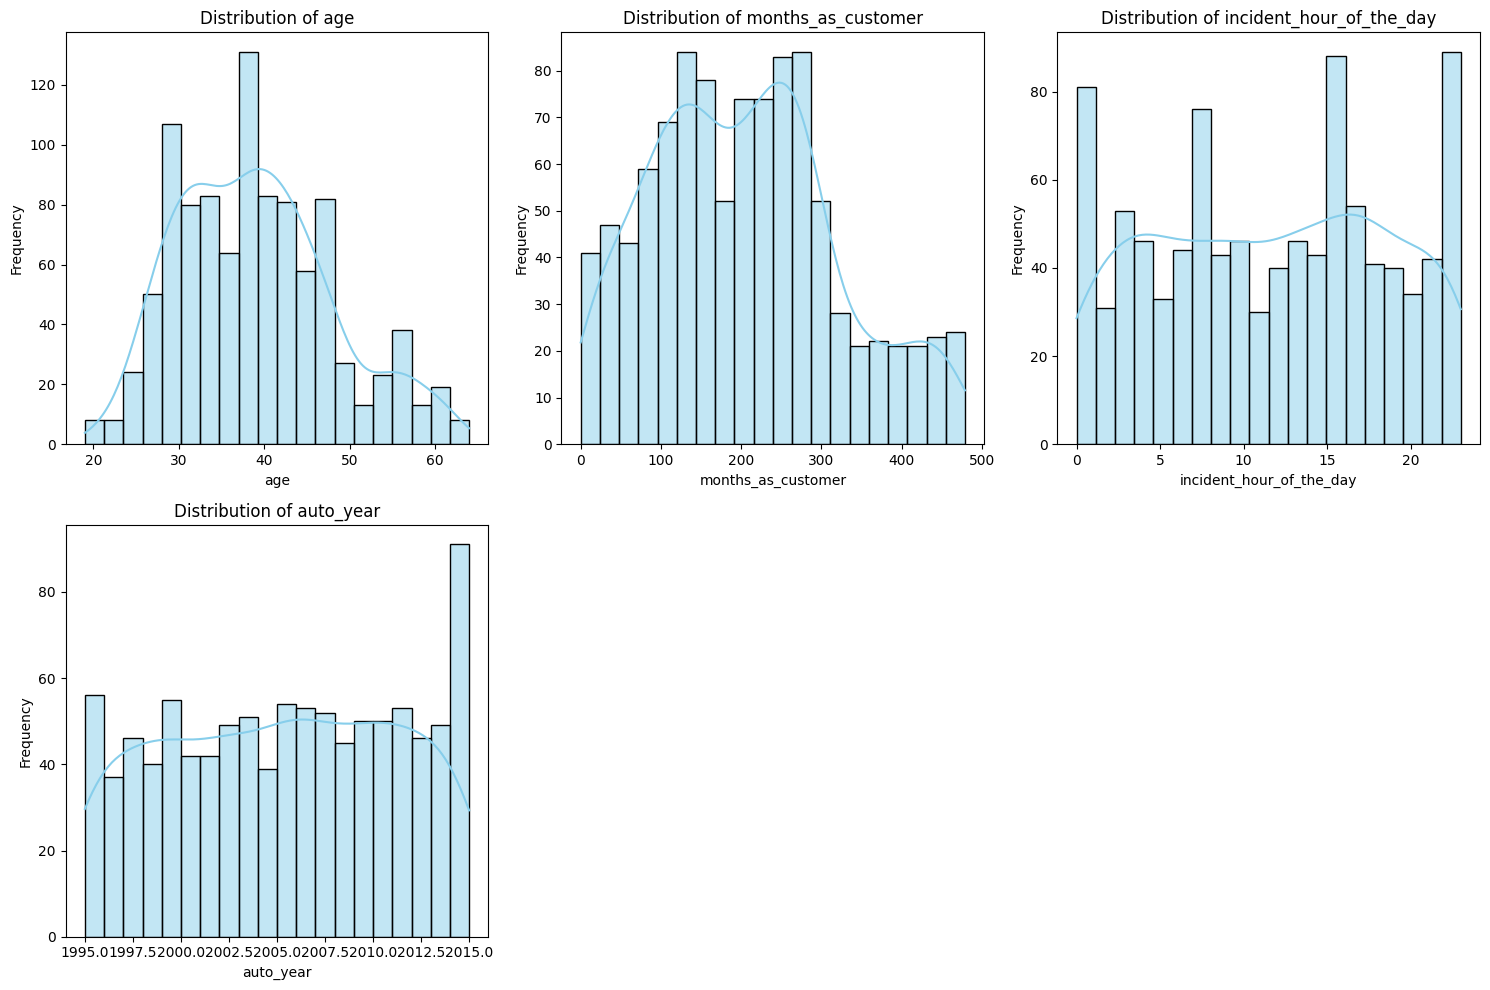

In [16]:
numerical_features = ['age', 'months_as_customer', 'incident_hour_of_the_day', 'auto_year']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(new_df[feature], kde=True, bins=20, color='skyblue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

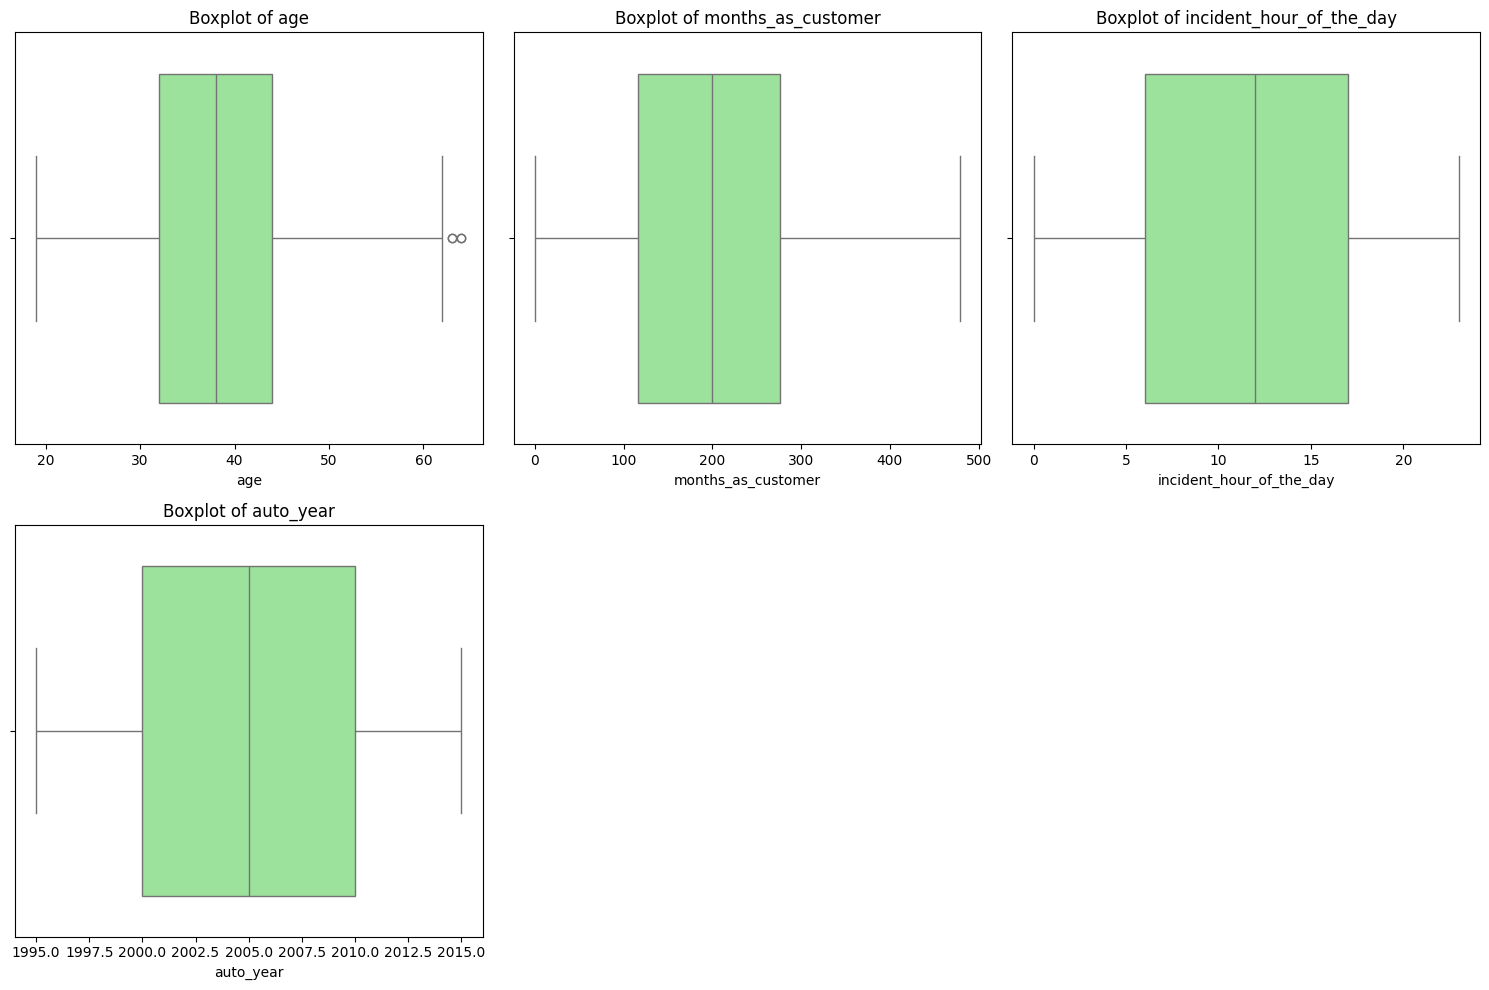

In [17]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=new_df[feature], color='lightgreen')
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)
plt.tight_layout()
plt.show()

# Checking ordinal features

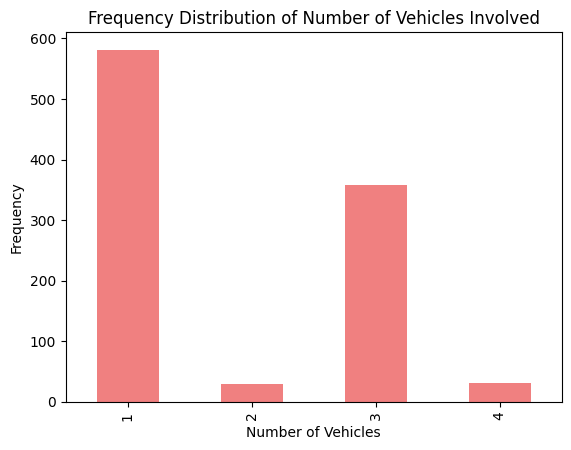

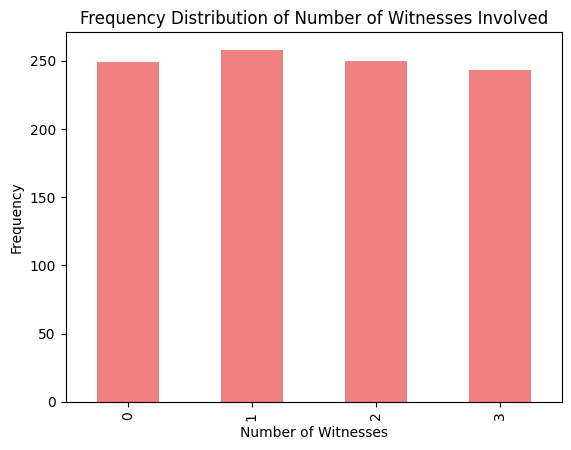

In [18]:
new_df['number_of_vehicles_involved'].value_counts().sort_index().plot(kind='bar', color='lightcoral')
plt.title('Frequency Distribution of Number of Vehicles Involved')
plt.xlabel('Number of Vehicles')
plt.ylabel('Frequency')
plt.show()

new_df['witnesses'].value_counts().sort_index().plot(kind='bar', color='lightcoral')
plt.title('Frequency Distribution of Number of Witnesses Involved')
plt.xlabel('Number of Witnesses')
plt.ylabel('Frequency')
plt.show()

# identifying outliers (there are none)

In [19]:
from scipy.stats import zscore

# Calculate Z-scores for the numerical features
z_scores = new_df[['age', 'months_as_customer', 'witnesses', 'number_of_vehicles_involved',
                   'incident_hour_of_the_day', 'auto_year']].apply(zscore)

# Identify outliers (Z-score > 3 or Z-score < -3)
outliers = (z_scores.abs() > 3)
print(outliers)
outliers.value_counts()


       age  months_as_customer  witnesses  number_of_vehicles_involved  \
0    False               False      False                        False   
1    False               False      False                        False   
2    False               False      False                        False   
3    False               False      False                        False   
4    False               False      False                        False   
..     ...                 ...        ...                          ...   
995  False               False      False                        False   
996  False               False      False                        False   
997  False               False      False                        False   
998  False               False      False                        False   
999  False               False      False                        False   

     incident_hour_of_the_day  auto_year  
0                       False      False  
1                       F

,,,,,,count
age,months_as_customer,witnesses,number_of_vehicles_involved,incident_hour_of_the_day,auto_year,
False,False,False,False,False,False,1000


# encoding categorical features  

In [20]:
new_df['weekend'] = new_df['weekend'].replace({'Y': 1, 'N': 0})
new_df['fraud_reported'] = new_df['fraud_reported'].replace({'Y': 1, 'N': 0})

new_df.head()

<ipython-input-20-b78a2f7c5ff4>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_df['weekend'] = new_df['weekend'].replace({'Y': 1, 'N': 0})
<ipython-input-20-b78a2f7c5ff4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['weekend'] = new_df['weekend'].replace({'Y': 1, 'N': 0})
<ipython-input-20-b78a2f7c5ff4>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to th

,age,months_as_customer,witnesses,number_of_vehicles_involved,police_report_available,incident_date,incident_hour_of_the_day,incident_type,auto_model,auto_year,weekend,fraud_reported
0,48,328,2,1,YES,2015-01-25,5,Single Vehicle Collision,92x,2004,1,1
1,42,228,0,1,?,2015-01-21,8,Vehicle Theft,E400,2007,0,1
2,29,134,3,3,NO,2015-02-22,7,Multi-vehicle Collision,RAM,2007,1,0
3,41,256,2,1,NO,2015-01-10,5,Single Vehicle Collision,Tahoe,2014,1,1
4,44,228,1,1,NO,2015-02-17,20,Vehicle Theft,RSX,2009,0,0


In [21]:
police_report_distribution = new_df['police_report_available'].value_counts()
incident_type_distribution = new_df['incident_type'].value_counts()
auto_model_distribution = new_df['auto_model'].value_counts()


print(police_report_distribution)
print(incident_type_distribution)
print(auto_model_distribution)

police_report_available
?      343
NO     343
YES    314
Name: count, dtype: int64
incident_type
Multi-vehicle Collision     419
Single Vehicle Collision    403
Vehicle Theft                94
Parked Car                   84
Name: count, dtype: int64
auto_model
RAM               43
Wrangler          42
A3                37
Neon              37
MDX               36
Jetta             35
Passat            33
A5                32
Legacy            32
Pathfinder        31
Malibu            30
92x               28
Camry             28
Forrestor         28
F150              27
95                27
E400              27
93                25
Grand Cherokee    25
Escape            24
Tahoe             24
Maxima            24
Ultima            23
X5                23
Highlander        22
Civic             22
Silverado         22
Fusion            21
ML350             20
Impreza           20
Corolla           20
TL                20
CRV               20
C300              18
3 Series          18
X6 

In [22]:
# Apply One-Hot Encoding to 'auto_model' feature
new_df = pd.get_dummies(new_df, columns=['auto_model'], prefix='auto_model', drop_first=False)

# Ensure all dummy variables are integers (0 and 1)
dummy_columns = [col for col in new_df.columns if 'auto_model_' in col]
new_df[dummy_columns] = new_df[dummy_columns].astype(int)

# Check the result
new_df.head()

,age,months_as_customer,witnesses,number_of_vehicles_involved,police_report_available,incident_date,incident_hour_of_the_day,incident_type,auto_year,weekend,...,auto_model_Pathfinder,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6
0,48,328,2,1,YES,2015-01-25,5,Single Vehicle Collision,2004,1,...,0,0,0,0,0,0,0,0,0,0
1,42,228,0,1,?,2015-01-21,8,Vehicle Theft,2007,0,...,0,0,0,0,0,0,0,0,0,0
2,29,134,3,3,NO,2015-02-22,7,Multi-vehicle Collision,2007,1,...,0,1,0,0,0,0,0,0,0,0
3,41,256,2,1,NO,2015-01-10,5,Single Vehicle Collision,2014,1,...,0,0,0,0,0,1,0,0,0,0
4,44,228,1,1,NO,2015-02-17,20,Vehicle Theft,2009,0,...,0,0,1,0,0,0,0,0,0,0


In [23]:
# Apply One-Hot Encoding

# Fixing the SettingWithCopyWarning using .loc

new_df = pd.get_dummies(new_df, columns=['police_report_available'], prefix='police_report', drop_first=False)

# Ensure all dummy variables are integers (0 and 1)
dummy_columns = [col for col in new_df.columns if 'police_report' in col]
new_df[dummy_columns] = new_df[dummy_columns].astype(int)

# Check the result
new_df.head()


,age,months_as_customer,witnesses,number_of_vehicles_involved,incident_date,incident_hour_of_the_day,incident_type,auto_year,weekend,fraud_reported,...,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6,police_report_?,police_report_NO,police_report_YES
0,48,328,2,1,2015-01-25,5,Single Vehicle Collision,2004,1,1,...,0,0,0,0,0,0,0,0,0,1
1,42,228,0,1,2015-01-21,8,Vehicle Theft,2007,0,1,...,0,0,0,0,0,0,0,1,0,0
2,29,134,3,3,2015-02-22,7,Multi-vehicle Collision,2007,1,0,...,0,0,0,0,0,0,0,0,1,0
3,41,256,2,1,2015-01-10,5,Single Vehicle Collision,2014,1,1,...,0,0,1,0,0,0,0,0,1,0
4,44,228,1,1,2015-02-17,20,Vehicle Theft,2009,0,0,...,0,0,0,0,0,0,0,0,1,0


In [24]:
# Apply One-Hot Encoding to 'incident_type' feature
new_df = pd.get_dummies(new_df, columns=['incident_type'], prefix='incident_type', drop_first=False)

# Ensure all dummy variables are integers (0 and 1)
dummy_columns = [col for col in new_df.columns if 'incident_type' in col]
new_df[dummy_columns] = new_df[dummy_columns].astype(int)

# Check the result
new_df.head()

,age,months_as_customer,witnesses,number_of_vehicles_involved,incident_date,incident_hour_of_the_day,auto_year,weekend,fraud_reported,auto_model_3 Series,...,auto_model_Wrangler,auto_model_X5,auto_model_X6,police_report_?,police_report_NO,police_report_YES,incident_type_Multi-vehicle Collision,incident_type_Parked Car,incident_type_Single Vehicle Collision,incident_type_Vehicle Theft
0,48,328,2,1,2015-01-25,5,2004,1,1,0,...,0,0,0,0,0,1,0,0,1,0
1,42,228,0,1,2015-01-21,8,2007,0,1,0,...,0,0,0,1,0,0,0,0,0,1
2,29,134,3,3,2015-02-22,7,2007,1,0,0,...,0,0,0,0,1,0,1,0,0,0
3,41,256,2,1,2015-01-10,5,2014,1,1,0,...,0,0,0,0,1,0,0,0,1,0
4,44,228,1,1,2015-02-17,20,2009,0,0,0,...,0,0,0,0,1,0,0,0,0,1


# extract features from incident date

In [25]:
# Extract useful features from the 'incident_date'
new_df['incident_year'] = new_df['incident_date'].dt.year
new_df['incident_month'] = new_df['incident_date'].dt.month

# Drop the original 'incident_date' column
new_df = new_df.drop('incident_date', axis=1)

new_df.head()

,age,months_as_customer,witnesses,number_of_vehicles_involved,incident_hour_of_the_day,auto_year,weekend,fraud_reported,auto_model_3 Series,auto_model_92x,...,auto_model_X6,police_report_?,police_report_NO,police_report_YES,incident_type_Multi-vehicle Collision,incident_type_Parked Car,incident_type_Single Vehicle Collision,incident_type_Vehicle Theft,incident_year,incident_month
0,48,328,2,1,5,2004,1,1,0,1,...,0,0,0,1,0,0,1,0,2015,1
1,42,228,0,1,8,2007,0,1,0,0,...,0,1,0,0,0,0,0,1,2015,1
2,29,134,3,3,7,2007,1,0,0,0,...,0,0,1,0,1,0,0,0,2015,2
3,41,256,2,1,5,2014,1,1,0,0,...,0,0,1,0,0,0,1,0,2015,1
4,44,228,1,1,20,2009,0,0,0,0,...,0,0,1,0,0,0,0,1,2015,2


# Building the Random Forest (Without SMOTE) - Best

In [26]:
print(new_df.dtypes)


age                                       int64
months_as_customer                        int64
witnesses                                 int64
number_of_vehicles_involved               int64
incident_hour_of_the_day                  int64
auto_year                                 int64
weekend                                   int64
fraud_reported                            int64
auto_model_3 Series                       int64
auto_model_92x                            int64
auto_model_93                             int64
auto_model_95                             int64
auto_model_A3                             int64
auto_model_A5                             int64
auto_model_Accord                         int64
auto_model_C300                           int64
auto_model_CRV                            int64
auto_model_Camry                          int64
auto_model_Civic                          int64
auto_model_Corolla                        int64
auto_model_E400                         

In [27]:
categorical_columns = new_df.select_dtypes(include=['object', 'category', 'bool']).columns
print("\nCategorical Columns:")
print(categorical_columns)


Categorical Columns:
Index([], dtype='object')


In [28]:
# Splitting the dataset

# Define features and target variable
X = new_df.drop('fraud_reported', axis=1)  # All columns except 'fraud_reported'
y = new_df['fraud_reported']  # Target variable

# Split the data into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Define hyperparameters



In [29]:
def objective(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5])
    class_weight = trial.suggest_categorical('class_weight', ['balanced'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 100)

    # Initialize the Random Forest model
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight=class_weight,
        max_leaf_nodes=max_leaf_nodes,
        random_state=42
    )

    # Perform 3-fold stratified cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Custom scorer to count true positives
    def true_positive_scorer(model, X, y):
        # Get predicted probabilities
        probs = model.predict_proba(X)[:, 1]  # Probabilities for the positive class (fraudulent)
        predictions = (probs >= 0.5).astype(int)  # Apply threshold
        true_positives = ((predictions == 1) & (y == 1)).sum()  # Count of true positives
        return true_positives

    # Use cross-validation and custom scoring
    total_true_positives = 0
    for train_index, test_index in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        rf.fit(X_train_fold, y_train_fold)
        fold_true_positives = true_positive_scorer(rf, X_test_fold, y_test_fold)
        total_true_positives += fold_true_positives

    # Log the total number of true positives
    print(f"Total True Positives (Fraudulent Cases Correctly Predicted): {total_true_positives}")

    return total_true_positives  # Optimize for the count of true positives



In [30]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-12-01 10:58:30,529] A new study created in memory with name: no-name-f1f06d20-553e-4d5c-9443-4cebf9946802
[I 2024-12-01 10:58:31,760] Trial 0 finished with value: 48.0 and parameters: {'n_estimators': 77, 'max_depth': 13, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 34}. Best is trial 0 with value: 48.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 48


[I 2024-12-01 10:58:34,707] Trial 1 finished with value: 45.0 and parameters: {'n_estimators': 114, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 90}. Best is trial 0 with value: 48.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 45


[I 2024-12-01 10:58:36,203] Trial 2 finished with value: 56.0 and parameters: {'n_estimators': 92, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 91}. Best is trial 2 with value: 56.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 56


[I 2024-12-01 10:58:38,774] Trial 3 finished with value: 61.0 and parameters: {'n_estimators': 187, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 67}. Best is trial 3 with value: 61.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 61


[I 2024-12-01 10:58:40,608] Trial 4 finished with value: 22.0 and parameters: {'n_estimators': 172, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 67}. Best is trial 3 with value: 61.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 22


[I 2024-12-01 10:58:42,233] Trial 5 finished with value: 68.0 and parameters: {'n_estimators': 131, 'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 89}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 68


[I 2024-12-01 10:58:45,215] Trial 6 finished with value: 19.0 and parameters: {'n_estimators': 193, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 93}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 19


[I 2024-12-01 10:58:48,903] Trial 7 finished with value: 61.0 and parameters: {'n_estimators': 175, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 53}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 61


[I 2024-12-01 10:58:51,318] Trial 8 finished with value: 59.0 and parameters: {'n_estimators': 140, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 81}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 59


[I 2024-12-01 10:58:52,736] Trial 9 finished with value: 59.0 and parameters: {'n_estimators': 154, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 95}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 59


[I 2024-12-01 10:58:54,701] Trial 10 finished with value: 44.0 and parameters: {'n_estimators': 110, 'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 13}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 44


[I 2024-12-01 10:58:55,431] Trial 11 finished with value: 60.0 and parameters: {'n_estimators': 53, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 66}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 60


[I 2024-12-01 10:58:58,827] Trial 12 finished with value: 34.0 and parameters: {'n_estimators': 195, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 70}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 34


[I 2024-12-01 10:59:02,486] Trial 13 finished with value: 35.0 and parameters: {'n_estimators': 140, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 43}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 35


[I 2024-12-01 10:59:05,115] Trial 14 finished with value: 63.0 and parameters: {'n_estimators': 163, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 79}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 63


[I 2024-12-01 10:59:05,918] Trial 15 finished with value: 58.0 and parameters: {'n_estimators': 159, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 79}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 58


[I 2024-12-01 10:59:06,892] Trial 16 finished with value: 25.0 and parameters: {'n_estimators': 137, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 77}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 25


[I 2024-12-01 10:59:07,627] Trial 17 finished with value: 58.0 and parameters: {'n_estimators': 122, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 100}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 58


[I 2024-12-01 10:59:08,175] Trial 18 finished with value: 55.0 and parameters: {'n_estimators': 97, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 54}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 55


[I 2024-12-01 10:59:08,976] Trial 19 finished with value: 60.0 and parameters: {'n_estimators': 156, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 83}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 60


[I 2024-12-01 10:59:09,770] Trial 20 finished with value: 52.0 and parameters: {'n_estimators': 130, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 22}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 52


[I 2024-12-01 10:59:10,667] Trial 21 finished with value: 54.0 and parameters: {'n_estimators': 176, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 71}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 54


[I 2024-12-01 10:59:11,628] Trial 22 finished with value: 60.0 and parameters: {'n_estimators': 187, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 61}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 60


[I 2024-12-01 10:59:12,486] Trial 23 finished with value: 59.0 and parameters: {'n_estimators': 163, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 85}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 59


[I 2024-12-01 10:59:13,252] Trial 24 finished with value: 65.0 and parameters: {'n_estimators': 147, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 61}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 65


[I 2024-12-01 10:59:14,051] Trial 25 finished with value: 60.0 and parameters: {'n_estimators': 146, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 44}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 60


[I 2024-12-01 10:59:15,217] Trial 26 finished with value: 52.0 and parameters: {'n_estimators': 125, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 75}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 52


[I 2024-12-01 10:59:16,604] Trial 27 finished with value: 50.0 and parameters: {'n_estimators': 169, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 59}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 50


[I 2024-12-01 10:59:17,720] Trial 28 finished with value: 62.0 and parameters: {'n_estimators': 145, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 47}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 62


[I 2024-12-01 10:59:18,433] Trial 29 finished with value: 34.0 and parameters: {'n_estimators': 101, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 31}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 34


[I 2024-12-01 10:59:18,899] Trial 30 finished with value: 62.0 and parameters: {'n_estimators': 84, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 100}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 62


[I 2024-12-01 10:59:19,650] Trial 31 finished with value: 61.0 and parameters: {'n_estimators': 148, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 47}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 61


[I 2024-12-01 10:59:20,338] Trial 32 finished with value: 59.0 and parameters: {'n_estimators': 132, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 36}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 59


[I 2024-12-01 10:59:20,975] Trial 33 finished with value: 49.0 and parameters: {'n_estimators': 117, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 49}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 49


[I 2024-12-01 10:59:21,809] Trial 34 finished with value: 43.0 and parameters: {'n_estimators': 148, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 87}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 43


[I 2024-12-01 10:59:22,684] Trial 35 finished with value: 48.0 and parameters: {'n_estimators': 163, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 36}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 48


[I 2024-12-01 10:59:23,281] Trial 36 finished with value: 50.0 and parameters: {'n_estimators': 108, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 59}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 50


[I 2024-12-01 10:59:24,207] Trial 37 finished with value: 65.0 and parameters: {'n_estimators': 180, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 63}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 65


[I 2024-12-01 10:59:25,144] Trial 38 finished with value: 62.0 and parameters: {'n_estimators': 182, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 64}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 62


[I 2024-12-01 10:59:26,215] Trial 39 finished with value: 41.0 and parameters: {'n_estimators': 199, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 72}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 41


[I 2024-12-01 10:59:27,131] Trial 40 finished with value: 44.0 and parameters: {'n_estimators': 168, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 90}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 44


[I 2024-12-01 10:59:28,083] Trial 41 finished with value: 61.0 and parameters: {'n_estimators': 152, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 54}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 61


[I 2024-12-01 10:59:29,502] Trial 42 finished with value: 57.0 and parameters: {'n_estimators': 179, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 62}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 57


[I 2024-12-01 10:59:30,661] Trial 43 finished with value: 64.0 and parameters: {'n_estimators': 133, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 40}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 64


[I 2024-12-01 10:59:31,486] Trial 44 finished with value: 66.0 and parameters: {'n_estimators': 136, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 29}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 66


[I 2024-12-01 10:59:32,201] Trial 45 finished with value: 58.0 and parameters: {'n_estimators': 132, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 26}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 58


[I 2024-12-01 10:59:32,846] Trial 46 finished with value: 62.0 and parameters: {'n_estimators': 123, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 41}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 62


[I 2024-12-01 10:59:33,470] Trial 47 finished with value: 63.0 and parameters: {'n_estimators': 115, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 21}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 63


[I 2024-12-01 10:59:34,236] Trial 48 finished with value: 45.0 and parameters: {'n_estimators': 135, 'max_depth': 14, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 14}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 45


[I 2024-12-01 10:59:34,632] Trial 49 finished with value: 59.0 and parameters: {'n_estimators': 69, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 30}. Best is trial 5 with value: 68.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 59


In [31]:
# The best parameters:

print("Best parameters:", study.best_params)
print("Best recall:", study.best_value)

Best parameters: {'n_estimators': 131, 'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 89}
Best recall: 68.0


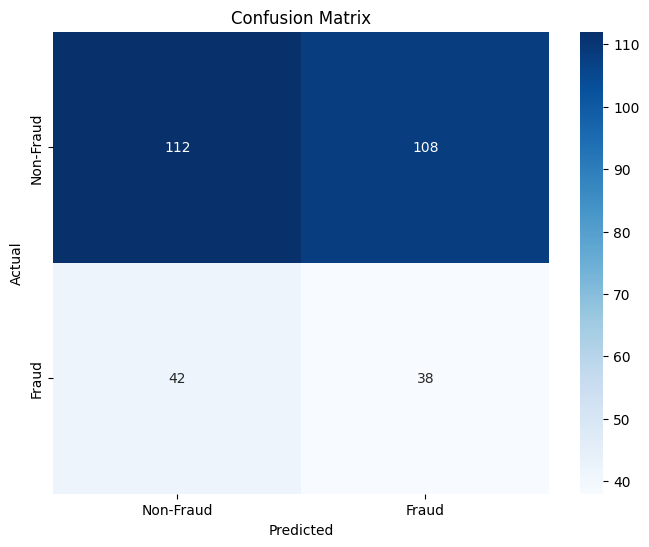

Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.51      0.60       220
           1       0.26      0.47      0.34        80

    accuracy                           0.50       300
   macro avg       0.49      0.49      0.47       300
weighted avg       0.60      0.50      0.53       300



In [32]:
# Train the model with the best parameters
best_params = study.best_params
rf_best = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    class_weight=best_params['class_weight'],
    random_state=80
)

# Fit on training data
rf_best.fit(X_train, y_train)

# Evaluate on the test set
probs_test = rf_best.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
threshold = 0.49
y_pred = (probs_test >= threshold).astype(int)



# Generate the confusion matrix
cm1 = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Print the classification report (precision, recall, F1 score)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))


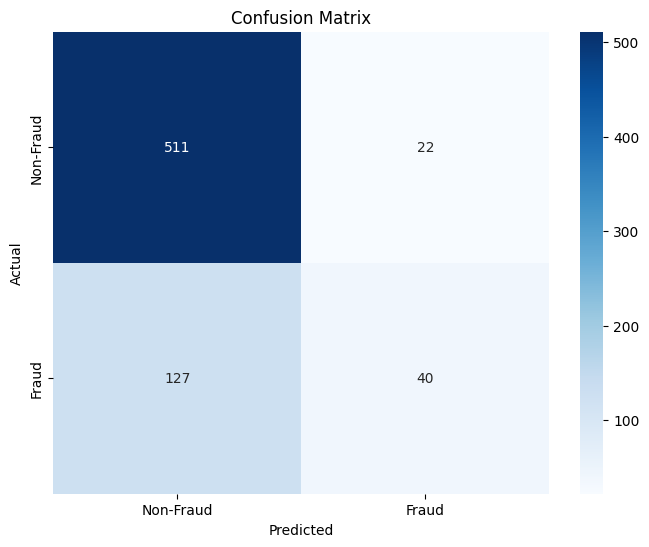

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.96      0.87       533
           1       0.65      0.24      0.35       167

    accuracy                           0.79       700
   macro avg       0.72      0.60      0.61       700
weighted avg       0.76      0.79      0.75       700



In [33]:
probs_train = rf_best.predict_proba(X_train)[:, 1]
y_train_pred = (probs_train >= 0.53).astype(int)


# Generate the confusion matrix
cm = confusion_matrix(y_train, y_train_pred)

# Plot confusion matrix using seaborn heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Print the classification report (precision, recall, F1 score)
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred))

In [34]:
# plot of optimization history

optuna.visualization.plot_optimization_history(study).show()

In [35]:
# plot of hyperparameter importance

optuna.visualization.plot_param_importances(study).show()

Get the feature importances

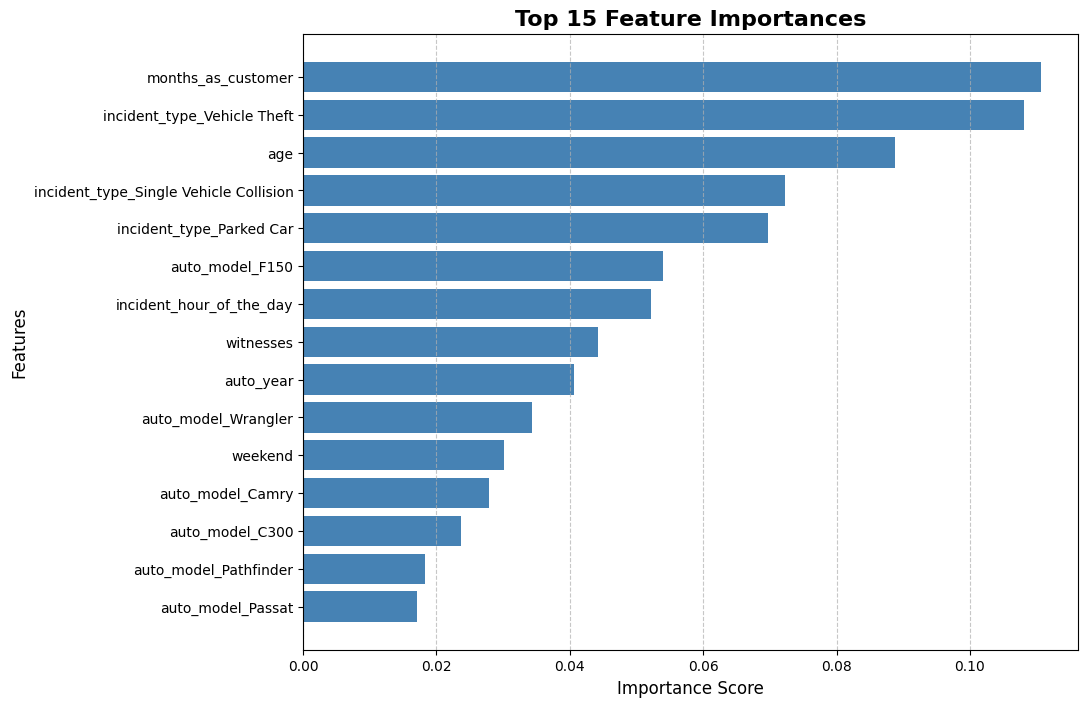

In [36]:
# Get feature importances from the final model
feature_importances = rf_best.feature_importances_
feature_names = X_train.columns

# Create a DataFrame to sort and select the top 15 features
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).head(15)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
plt.gca().invert_yaxis()  # To show the most important feature on top
plt.title('Top 15 Feature Importances', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add light gridlines for the x-axis
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [37]:
# Splitting the dataset

# Define features and target variable
X = new_df.drop('fraud_reported', axis=1)  # All columns except 'fraud_reported'
y = new_df['fraud_reported']  # Target variable

# Split the data into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Model evaluation

In [38]:
def objective(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    class_weight = trial.suggest_categorical('class_weight', ['balanced'])

    # Initialize the Random Forest model
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight=class_weight,
        random_state=42
    )

    # Perform 3-fold stratified cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Custom scorer without requiring additional arguments
    def thresholded_recall_scorer(model, X, y):
        # Get predicted probabilities
        probs = model.predict_proba(X)[:, 1]  # Probabilities for the positive class (fraudulent)
        predictions = (probs >= 0.3).astype(int)  # Apply threshold
        recall = recall_score(y, predictions, pos_label=1)  # Recall for fraudulent cases
        precision = precision_score(y, predictions, pos_label=1, zero_division=0)  # Precision for fraudulent cases

        # Penalize if precision is too low (e.g., < 0.3)
        if precision < 0.3:
            return recall * 0.5  # Penalize recall when precision is too low
        return recall

    # Use cross-validation and custom scoring
    recall_scores = []
    for train_index, test_index in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        rf.fit(X_train_fold, y_train_fold)
        score = thresholded_recall_scorer(rf, X_test_fold, y_test_fold)
        recall_scores.append(score)

    # Calculate the mean recall score
    avg_recall = np.mean(recall_scores)

    # Log the recall scores
    print(f"Average Recall for fraudulent cases: {avg_recall:.4f}")

    return avg_recall



In [39]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-12-01 10:59:37,484] A new study created in memory with name: no-name-74318347-bb6e-4dfc-adbe-ec85b05c5ec3
[I 2024-12-01 10:59:38,351] Trial 0 finished with value: 0.46677489177489173 and parameters: {'n_estimators': 146, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 5, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.46677489177489173.


Average Recall for fraudulent cases: 0.4668


[I 2024-12-01 10:59:39,778] Trial 1 finished with value: 0.4788419913419913 and parameters: {'n_estimators': 280, 'max_depth': 37, 'min_samples_split': 10, 'min_samples_leaf': 8, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.4788419913419913.


Average Recall for fraudulent cases: 0.4788


[I 2024-12-01 10:59:41,402] Trial 2 finished with value: 0.4428571428571429 and parameters: {'n_estimators': 252, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 4, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.4788419913419913.


Average Recall for fraudulent cases: 0.4429


[I 2024-12-01 10:59:43,158] Trial 3 finished with value: 0.4758116883116883 and parameters: {'n_estimators': 218, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 3, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.4788419913419913.


Average Recall for fraudulent cases: 0.4758


[I 2024-12-01 10:59:44,718] Trial 4 finished with value: 0.4758658008658008 and parameters: {'n_estimators': 227, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 7, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.4788419913419913.


Average Recall for fraudulent cases: 0.4759


[I 2024-12-01 10:59:46,253] Trial 5 finished with value: 0.4727813852813853 and parameters: {'n_estimators': 287, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 4, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.4788419913419913.


Average Recall for fraudulent cases: 0.4728


[I 2024-12-01 10:59:47,319] Trial 6 finished with value: 0.4758658008658008 and parameters: {'n_estimators': 193, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 6, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.4788419913419913.


Average Recall for fraudulent cases: 0.4759


[I 2024-12-01 10:59:48,453] Trial 7 finished with value: 0.4577922077922078 and parameters: {'n_estimators': 209, 'max_depth': 38, 'min_samples_split': 3, 'min_samples_leaf': 5, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.4788419913419913.


Average Recall for fraudulent cases: 0.4578


[I 2024-12-01 10:59:49,167] Trial 8 finished with value: 0.4818722943722944 and parameters: {'n_estimators': 132, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 5, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.4818722943722944.


Average Recall for fraudulent cases: 0.4819


[I 2024-12-01 10:59:50,509] Trial 9 finished with value: 0.48787878787878786 and parameters: {'n_estimators': 265, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 10, 'class_weight': 'balanced'}. Best is trial 9 with value: 0.48787878787878786.


Average Recall for fraudulent cases: 0.4879


[I 2024-12-01 10:59:50,834] Trial 10 finished with value: 0.48484848484848486 and parameters: {'n_estimators': 50, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 10, 'class_weight': 'balanced'}. Best is trial 9 with value: 0.48787878787878786.


Average Recall for fraudulent cases: 0.4848


[I 2024-12-01 10:59:51,173] Trial 11 finished with value: 0.48484848484848486 and parameters: {'n_estimators': 52, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 10, 'class_weight': 'balanced'}. Best is trial 9 with value: 0.48787878787878786.


Average Recall for fraudulent cases: 0.4848


[I 2024-12-01 10:59:51,567] Trial 12 finished with value: 0.48484848484848486 and parameters: {'n_estimators': 61, 'max_depth': 29, 'min_samples_split': 5, 'min_samples_leaf': 10, 'class_weight': 'balanced'}. Best is trial 9 with value: 0.48787878787878786.


Average Recall for fraudulent cases: 0.4848


[I 2024-12-01 10:59:52,213] Trial 13 finished with value: 0.4849025974025974 and parameters: {'n_estimators': 109, 'max_depth': 48, 'min_samples_split': 6, 'min_samples_leaf': 9, 'class_weight': 'balanced'}. Best is trial 9 with value: 0.48787878787878786.


Average Recall for fraudulent cases: 0.4849


[I 2024-12-01 10:59:52,956] Trial 14 finished with value: 0.2693722943722944 and parameters: {'n_estimators': 112, 'max_depth': 48, 'min_samples_split': 6, 'min_samples_leaf': 1, 'class_weight': 'balanced'}. Best is trial 9 with value: 0.48787878787878786.


Average Recall for fraudulent cases: 0.2694


[I 2024-12-01 10:59:53,516] Trial 15 finished with value: 0.4788419913419913 and parameters: {'n_estimators': 97, 'max_depth': 50, 'min_samples_split': 7, 'min_samples_leaf': 8, 'class_weight': 'balanced'}. Best is trial 9 with value: 0.48787878787878786.


Average Recall for fraudulent cases: 0.4788


[I 2024-12-01 10:59:54,578] Trial 16 finished with value: 0.4818722943722944 and parameters: {'n_estimators': 164, 'max_depth': 40, 'min_samples_split': 6, 'min_samples_leaf': 8, 'class_weight': 'balanced'}. Best is trial 9 with value: 0.48787878787878786.


Average Recall for fraudulent cases: 0.4819


[I 2024-12-01 10:59:55,362] Trial 17 finished with value: 0.4818722943722944 and parameters: {'n_estimators': 86, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 9, 'class_weight': 'balanced'}. Best is trial 9 with value: 0.48787878787878786.


Average Recall for fraudulent cases: 0.4819


[I 2024-12-01 10:59:57,412] Trial 18 finished with value: 0.48484848484848486 and parameters: {'n_estimators': 251, 'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 9, 'class_weight': 'balanced'}. Best is trial 9 with value: 0.48787878787878786.


Average Recall for fraudulent cases: 0.4848


[I 2024-12-01 10:59:58,532] Trial 19 finished with value: 0.4758658008658008 and parameters: {'n_estimators': 181, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 7, 'class_weight': 'balanced'}. Best is trial 9 with value: 0.48787878787878786.


Average Recall for fraudulent cases: 0.4759


[I 2024-12-01 10:59:59,367] Trial 20 finished with value: 0.4818722943722944 and parameters: {'n_estimators': 153, 'max_depth': 44, 'min_samples_split': 8, 'min_samples_leaf': 9, 'class_weight': 'balanced'}. Best is trial 9 with value: 0.48787878787878786.


Average Recall for fraudulent cases: 0.4819


[I 2024-12-01 10:59:59,814] Trial 21 finished with value: 0.48484848484848486 and parameters: {'n_estimators': 77, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 10, 'class_weight': 'balanced'}. Best is trial 9 with value: 0.48787878787878786.


Average Recall for fraudulent cases: 0.4848


[I 2024-12-01 11:00:00,502] Trial 22 finished with value: 0.48787878787878786 and parameters: {'n_estimators': 121, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 10, 'class_weight': 'balanced'}. Best is trial 9 with value: 0.48787878787878786.


Average Recall for fraudulent cases: 0.4879


[I 2024-12-01 11:00:01,191] Trial 23 finished with value: 0.4849025974025974 and parameters: {'n_estimators': 124, 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 9, 'class_weight': 'balanced'}. Best is trial 9 with value: 0.48787878787878786.


Average Recall for fraudulent cases: 0.4849


[I 2024-12-01 11:00:01,747] Trial 24 finished with value: 0.4759199134199134 and parameters: {'n_estimators': 98, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 7, 'class_weight': 'balanced'}. Best is trial 9 with value: 0.48787878787878786.


Average Recall for fraudulent cases: 0.4759


[I 2024-12-01 11:00:02,511] Trial 25 finished with value: 0.48787878787878786 and parameters: {'n_estimators': 140, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 10, 'class_weight': 'balanced'}. Best is trial 9 with value: 0.48787878787878786.


Average Recall for fraudulent cases: 0.4879


[I 2024-12-01 11:00:03,292] Trial 26 finished with value: 0.48787878787878786 and parameters: {'n_estimators': 139, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 10, 'class_weight': 'balanced'}. Best is trial 9 with value: 0.48787878787878786.


Average Recall for fraudulent cases: 0.4879


[I 2024-12-01 11:00:04,202] Trial 27 finished with value: 0.4788419913419913 and parameters: {'n_estimators': 169, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 8, 'class_weight': 'balanced'}. Best is trial 9 with value: 0.48787878787878786.


Average Recall for fraudulent cases: 0.4788


[I 2024-12-01 11:00:05,215] Trial 28 finished with value: 0.48484848484848486 and parameters: {'n_estimators': 193, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 10, 'class_weight': 'balanced'}. Best is trial 9 with value: 0.48787878787878786.


Average Recall for fraudulent cases: 0.4848


[I 2024-12-01 11:00:06,195] Trial 29 finished with value: 0.26931818181818185 and parameters: {'n_estimators': 153, 'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 1, 'class_weight': 'balanced'}. Best is trial 9 with value: 0.48787878787878786.


Average Recall for fraudulent cases: 0.2693


In [40]:
# The best parameters:

print("Best parameters:", study.best_params)
print("Best recall:", study.best_value)


Best parameters: {'n_estimators': 265, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 10, 'class_weight': 'balanced'}
Best recall: 0.48787878787878786


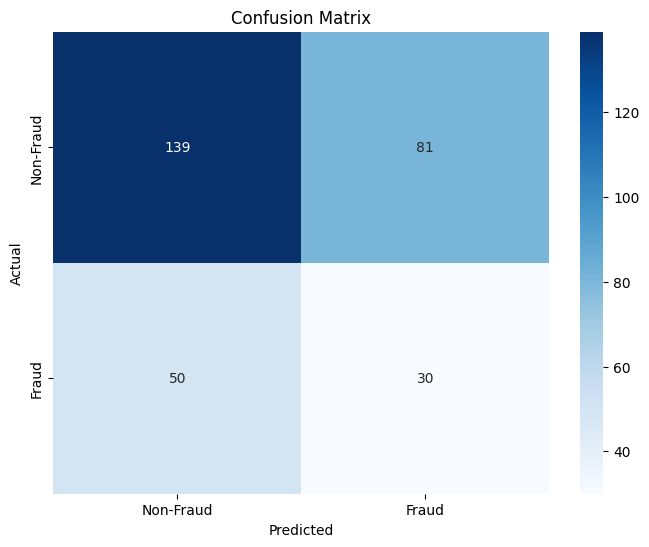

Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.63      0.68       220
           1       0.27      0.38      0.31        80

    accuracy                           0.56       300
   macro avg       0.50      0.50      0.50       300
weighted avg       0.61      0.56      0.58       300



In [41]:
# Train the model with the best parameters
best_params = study.best_params
rf_best = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    class_weight=best_params['class_weight'],
    random_state=42
)

# Fit on training data
rf_best.fit(X_train, y_train)

# Evaluate on the test set
from sklearn.metrics import classification_report, confusion_matrix

y_pred = rf_best.predict(X_test)


# Generate the confusion matrix
cm1 = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Print the classification report (precision, recall, F1 score)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))


Confusion Matrix of training set

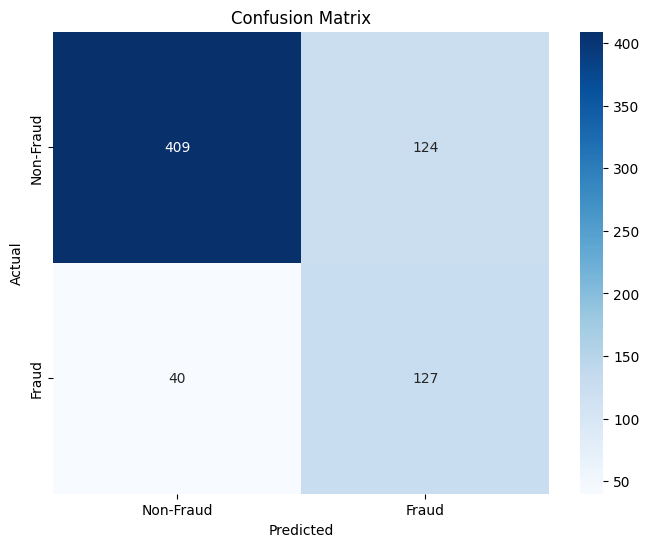

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.77      0.83       533
           1       0.51      0.76      0.61       167

    accuracy                           0.77       700
   macro avg       0.71      0.76      0.72       700
weighted avg       0.81      0.77      0.78       700



In [42]:
y_train_pred = rf_best.predict(X_train)

# Generate the confusion matrix
cm = confusion_matrix(y_train, y_train_pred)

# Plot confusion matrix using seaborn heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Print the classification report (precision, recall, F1 score)
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred))

In [43]:
# plot of optimization history

optuna.visualization.plot_optimization_history(study).show()


In [44]:
# plot of hyperparameter importance

optuna.visualization.plot_param_importances(study).show()


# Building the Random Forest (With SMOTE) - Best

In [72]:
def objective(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5])
    class_weight = trial.suggest_categorical('class_weight', ['balanced'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 100)
    smote_k_neighbors = trial.suggest_int('k_neighbors', 2, 10)

    # Initialize the Random Forest model
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight=class_weight,
        max_leaf_nodes=max_leaf_nodes,
        random_state=42
    )

    # Create a pipeline with SMOTE and the classifier
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42, k_neighbors=smote_k_neighbors)),
        ('classifier', rf)
    ])

    # Perform 3-fold stratified cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    def total_true_positives_scorer(model, X, y):
        # Get predicted probabilities
        probs = model.predict_proba(X)[:, 1]  # Probabilities for the positive class (fraudulent)
        predictions = (probs >= 0.5).astype(int)  # Apply threshold
        true_positives = ((predictions == 1) & (y == 1)).sum()  # Count of true positives
        return true_positives

    # Use cross-validation and custom scoring
    total_true_positives = 0
    for train_index, test_index in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Apply SMOTE only to the training fold
        smote = SMOTE(random_state=42, k_neighbors=smote_k_neighbors)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

        # Fit the pipeline
        pipeline.fit(X_train_resampled, y_train_resampled)
        fold_true_positives = total_true_positives_scorer(pipeline, X_test_fold, y_test_fold)
        total_true_positives += fold_true_positives

    # Log the total true positives
    print(f"Total True Positives (Fraudulent Cases Correctly Predicted): {total_true_positives}")

    return total_true_positives  # Optimize for the total number of true positives


In [73]:
import optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-12-01 12:22:57,751] A new study created in memory with name: no-name-2b144aba-011b-4dae-b01b-2b7b6e7b95cc
[I 2024-12-01 12:22:58,663] Trial 0 finished with value: 35.0 and parameters: {'n_estimators': 106, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 33, 'k_neighbors': 8}. Best is trial 0 with value: 35.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 35


[I 2024-12-01 12:22:59,859] Trial 1 finished with value: 41.0 and parameters: {'n_estimators': 187, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 93, 'k_neighbors': 9}. Best is trial 1 with value: 41.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 41


[I 2024-12-01 12:23:01,103] Trial 2 finished with value: 25.0 and parameters: {'n_estimators': 121, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 66, 'k_neighbors': 4}. Best is trial 1 with value: 41.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 25


[I 2024-12-01 12:23:02,218] Trial 3 finished with value: 29.0 and parameters: {'n_estimators': 91, 'max_depth': 14, 'min_samples_split': 19, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 15, 'k_neighbors': 4}. Best is trial 1 with value: 41.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 29


[I 2024-12-01 12:23:04,371] Trial 4 finished with value: 13.0 and parameters: {'n_estimators': 197, 'max_depth': 6, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 54, 'k_neighbors': 5}. Best is trial 1 with value: 41.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 13


[I 2024-12-01 12:23:05,168] Trial 5 finished with value: 15.0 and parameters: {'n_estimators': 78, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 68, 'k_neighbors': 4}. Best is trial 1 with value: 41.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 15


[I 2024-12-01 12:23:06,193] Trial 6 finished with value: 24.0 and parameters: {'n_estimators': 144, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 81, 'k_neighbors': 7}. Best is trial 1 with value: 41.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 24


[I 2024-12-01 12:23:07,103] Trial 7 finished with value: 14.0 and parameters: {'n_estimators': 88, 'max_depth': 14, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 30, 'k_neighbors': 10}. Best is trial 1 with value: 41.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 14


[I 2024-12-01 12:23:07,953] Trial 8 finished with value: 10.0 and parameters: {'n_estimators': 81, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 35, 'k_neighbors': 8}. Best is trial 1 with value: 41.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 10


[I 2024-12-01 12:23:09,109] Trial 9 finished with value: 42.0 and parameters: {'n_estimators': 181, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 15, 'k_neighbors': 5}. Best is trial 9 with value: 42.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 42


[I 2024-12-01 12:23:10,181] Trial 10 finished with value: 56.0 and parameters: {'n_estimators': 162, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 11, 'k_neighbors': 2}. Best is trial 10 with value: 56.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 56


[I 2024-12-01 12:23:11,250] Trial 11 finished with value: 56.0 and parameters: {'n_estimators': 162, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 10, 'k_neighbors': 2}. Best is trial 10 with value: 56.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 56


[I 2024-12-01 12:23:12,285] Trial 12 finished with value: 56.0 and parameters: {'n_estimators': 154, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 10, 'k_neighbors': 2}. Best is trial 10 with value: 56.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 56


[I 2024-12-01 12:23:13,363] Trial 13 finished with value: 54.0 and parameters: {'n_estimators': 160, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 47, 'k_neighbors': 2}. Best is trial 10 with value: 56.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 54


[I 2024-12-01 12:23:13,932] Trial 14 finished with value: 28.0 and parameters: {'n_estimators': 54, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 24, 'k_neighbors': 2}. Best is trial 10 with value: 56.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 28


[I 2024-12-01 12:23:15,572] Trial 15 finished with value: 48.0 and parameters: {'n_estimators': 170, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 43, 'k_neighbors': 3}. Best is trial 10 with value: 56.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 48


[I 2024-12-01 12:23:17,885] Trial 16 finished with value: 32.0 and parameters: {'n_estimators': 138, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 23, 'k_neighbors': 3}. Best is trial 10 with value: 56.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 32


[I 2024-12-01 12:23:18,912] Trial 17 finished with value: 53.0 and parameters: {'n_estimators': 127, 'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 10, 'k_neighbors': 6}. Best is trial 10 with value: 56.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 53


[I 2024-12-01 12:23:20,737] Trial 18 finished with value: 34.0 and parameters: {'n_estimators': 170, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 22, 'k_neighbors': 3}. Best is trial 10 with value: 56.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 34


[I 2024-12-01 12:23:21,846] Trial 19 finished with value: 40.0 and parameters: {'n_estimators': 152, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 41, 'k_neighbors': 6}. Best is trial 10 with value: 56.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 40


[I 2024-12-01 12:23:23,174] Trial 20 finished with value: 42.0 and parameters: {'n_estimators': 199, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 61, 'k_neighbors': 2}. Best is trial 10 with value: 56.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 42


[I 2024-12-01 12:23:24,258] Trial 21 finished with value: 53.0 and parameters: {'n_estimators': 161, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 10, 'k_neighbors': 2}. Best is trial 10 with value: 56.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 53


[I 2024-12-01 12:23:25,184] Trial 22 finished with value: 57.0 and parameters: {'n_estimators': 132, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 21, 'k_neighbors': 3}. Best is trial 22 with value: 57.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 57


[I 2024-12-01 12:23:26,120] Trial 23 finished with value: 53.0 and parameters: {'n_estimators': 134, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 20, 'k_neighbors': 3}. Best is trial 22 with value: 57.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 53


[I 2024-12-01 12:23:26,956] Trial 24 finished with value: 49.0 and parameters: {'n_estimators': 111, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 28, 'k_neighbors': 3}. Best is trial 22 with value: 57.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 49


[I 2024-12-01 12:23:28,185] Trial 25 finished with value: 51.0 and parameters: {'n_estimators': 145, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 17, 'k_neighbors': 4}. Best is trial 22 with value: 57.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 51


[I 2024-12-01 12:23:29,935] Trial 26 finished with value: 42.0 and parameters: {'n_estimators': 176, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 39, 'k_neighbors': 5}. Best is trial 22 with value: 57.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 42


[I 2024-12-01 12:23:31,208] Trial 27 finished with value: 49.0 and parameters: {'n_estimators': 117, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 26, 'k_neighbors': 2}. Best is trial 22 with value: 57.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 49


[I 2024-12-01 12:23:32,203] Trial 28 finished with value: 43.0 and parameters: {'n_estimators': 134, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 19, 'k_neighbors': 3}. Best is trial 22 with value: 57.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 43


[I 2024-12-01 12:23:32,966] Trial 29 finished with value: 53.0 and parameters: {'n_estimators': 101, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 31, 'k_neighbors': 4}. Best is trial 22 with value: 57.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 53


[I 2024-12-01 12:23:34,459] Trial 30 finished with value: 10.0 and parameters: {'n_estimators': 165, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 35, 'k_neighbors': 7}. Best is trial 22 with value: 57.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 10


[I 2024-12-01 12:23:35,476] Trial 31 finished with value: 57.0 and parameters: {'n_estimators': 152, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 10, 'k_neighbors': 2}. Best is trial 22 with value: 57.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 57


[I 2024-12-01 12:23:36,484] Trial 32 finished with value: 52.0 and parameters: {'n_estimators': 150, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 15, 'k_neighbors': 2}. Best is trial 22 with value: 57.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 52


[I 2024-12-01 12:23:37,714] Trial 33 finished with value: 60.0 and parameters: {'n_estimators': 188, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 10, 'k_neighbors': 3}. Best is trial 33 with value: 60.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 60


[I 2024-12-01 12:23:38,960] Trial 34 finished with value: 46.0 and parameters: {'n_estimators': 186, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 90, 'k_neighbors': 3}. Best is trial 33 with value: 60.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 46


[I 2024-12-01 12:23:40,207] Trial 35 finished with value: 52.0 and parameters: {'n_estimators': 190, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 16, 'k_neighbors': 4}. Best is trial 33 with value: 60.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 52


[I 2024-12-01 12:23:41,166] Trial 36 finished with value: 43.0 and parameters: {'n_estimators': 129, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 51, 'k_neighbors': 3}. Best is trial 33 with value: 60.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 43


[I 2024-12-01 12:23:42,852] Trial 37 finished with value: 37.0 and parameters: {'n_estimators': 177, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 14, 'k_neighbors': 5}. Best is trial 33 with value: 60.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 37


[I 2024-12-01 12:23:44,917] Trial 38 finished with value: 38.0 and parameters: {'n_estimators': 191, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 26, 'k_neighbors': 4}. Best is trial 33 with value: 60.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 38


[I 2024-12-01 12:23:45,825] Trial 39 finished with value: 30.0 and parameters: {'n_estimators': 119, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 76, 'k_neighbors': 10}. Best is trial 33 with value: 60.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 30


[I 2024-12-01 12:23:46,891] Trial 40 finished with value: 34.0 and parameters: {'n_estimators': 143, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 20, 'k_neighbors': 4}. Best is trial 33 with value: 60.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 34


[I 2024-12-01 12:23:48,001] Trial 41 finished with value: 56.0 and parameters: {'n_estimators': 169, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 10, 'k_neighbors': 2}. Best is trial 33 with value: 60.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 56


[I 2024-12-01 12:23:49,057] Trial 42 finished with value: 54.0 and parameters: {'n_estimators': 157, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 14, 'k_neighbors': 2}. Best is trial 33 with value: 60.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 54


[I 2024-12-01 12:23:50,216] Trial 43 finished with value: 58.0 and parameters: {'n_estimators': 181, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 13, 'k_neighbors': 3}. Best is trial 33 with value: 60.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 58


[I 2024-12-01 12:23:51,630] Trial 44 finished with value: 31.0 and parameters: {'n_estimators': 182, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 20, 'k_neighbors': 3}. Best is trial 33 with value: 60.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 31


[I 2024-12-01 12:23:53,001] Trial 45 finished with value: 44.0 and parameters: {'n_estimators': 192, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 14, 'k_neighbors': 4}. Best is trial 33 with value: 60.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 44


[I 2024-12-01 12:23:54,171] Trial 46 finished with value: 55.0 and parameters: {'n_estimators': 179, 'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 31, 'k_neighbors': 3}. Best is trial 33 with value: 60.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 55


[I 2024-12-01 12:23:55,632] Trial 47 finished with value: 51.0 and parameters: {'n_estimators': 173, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 23, 'k_neighbors': 9}. Best is trial 33 with value: 60.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 51


[I 2024-12-01 12:23:57,110] Trial 48 finished with value: 57.0 and parameters: {'n_estimators': 149, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 13, 'k_neighbors': 2}. Best is trial 33 with value: 60.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 57


[I 2024-12-01 12:23:59,875] Trial 49 finished with value: 28.0 and parameters: {'n_estimators': 148, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 60, 'k_neighbors': 5}. Best is trial 33 with value: 60.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 28


In [74]:
# Get the best hyperparameters from the Optuna study
best_params = study.best_params
print("Best Parameters:", best_params)

Best Parameters: {'n_estimators': 188, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 10, 'k_neighbors': 3}


Confusion Matrix:
 [[ 90 130]
 [ 27  53]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.41      0.53       220
           1       0.29      0.66      0.40        80

    accuracy                           0.48       300
   macro avg       0.53      0.54      0.47       300
weighted avg       0.64      0.48      0.50       300



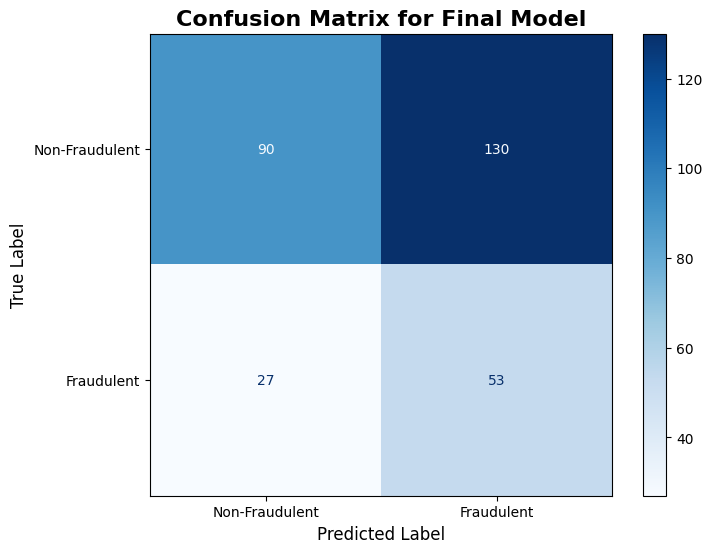

In [81]:
# Train the final model with the best parameters
best_params = study.best_params
rf_final = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    class_weight=best_params['class_weight'],
    random_state=42
)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42, k_neighbors=best_params['k_neighbors'])
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Fit the model on the resampled data
rf_final.fit(X_train_resampled, y_train_resampled)

# Evaluate on the test set
y_pred = (rf_final.predict_proba(X_test)[:, 1] >= 0.45).astype(int)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Non-Fraudulent', 'Fraudulent']

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d')

# Enhance the plot aesthetics
plt.title('Confusion Matrix for Final Model', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)  # Remove gridlines for a cleaner look
plt.show()

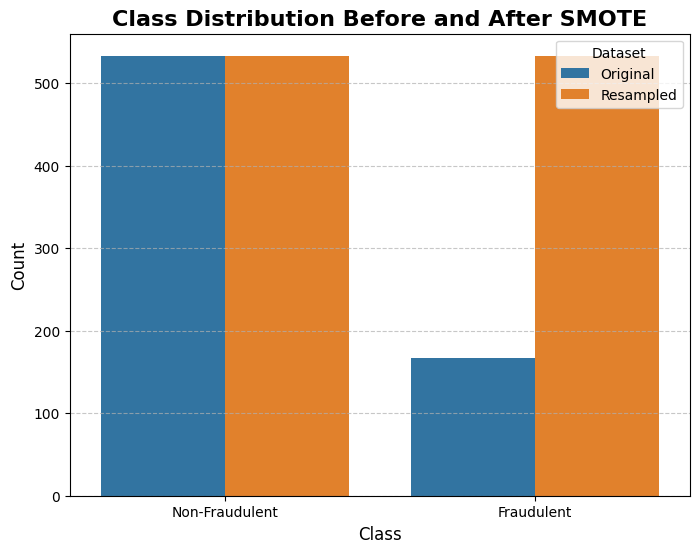

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Count the class distributions before and after SMOTE
original_counts = Counter(y_train)
resampled_counts = Counter(y_train_resampled)

# Create a dataframe for easier visualization
class_labels = ['Non-Fraudulent', 'Fraudulent']
df_counts = pd.DataFrame({
    'Class': class_labels,
    'Original': [original_counts[0], original_counts[1]],
    'Resampled': [resampled_counts[0], resampled_counts[1]]
})

# Melt the dataframe for use in seaborn
df_melted = df_counts.melt(id_vars='Class', var_name='Dataset', value_name='Count')

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.barplot(data=df_melted, x='Class', y='Count', hue='Dataset', palette=['#1f77b4', '#ff7f0e'])

# Enhance the plot aesthetics
plt.title('Class Distribution Before and After SMOTE', fontsize=16, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Dataset', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

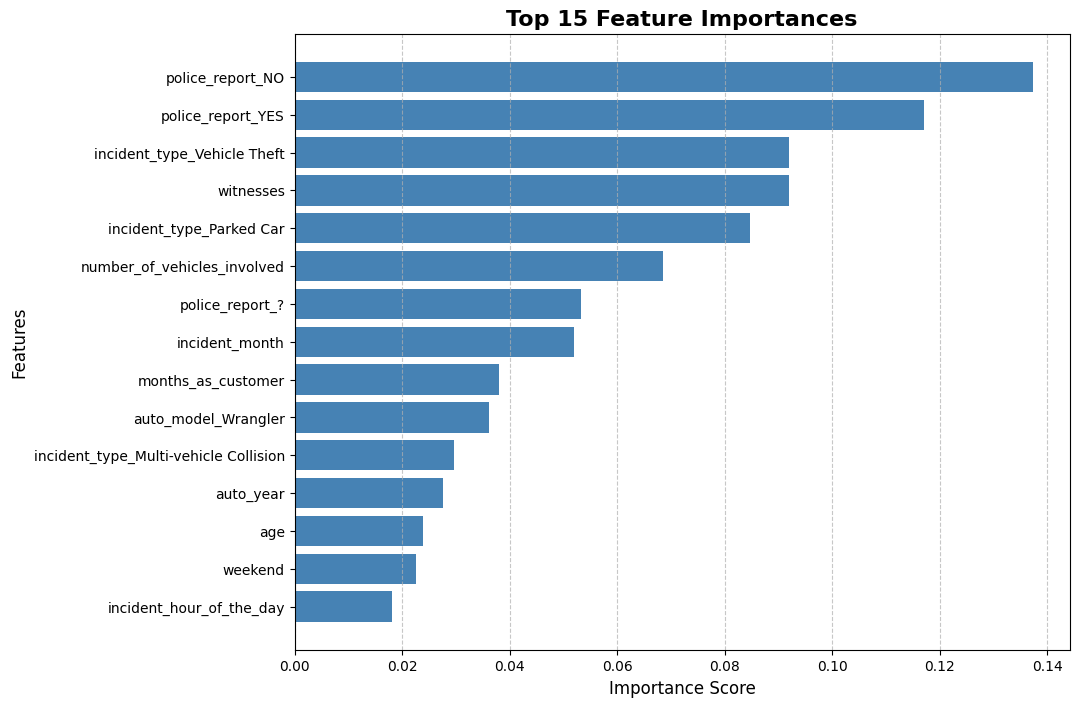

In [49]:
# Get feature importances from the final model
feature_importances = rf_final.feature_importances_
feature_names = X_train.columns

# Create a DataFrame to sort and select the top 15 features
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).head(15)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
plt.gca().invert_yaxis()  # To show the most important feature on top
plt.title('Top 15 Feature Importances', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add light gridlines for the x-axis
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Confusion Matrix of training set

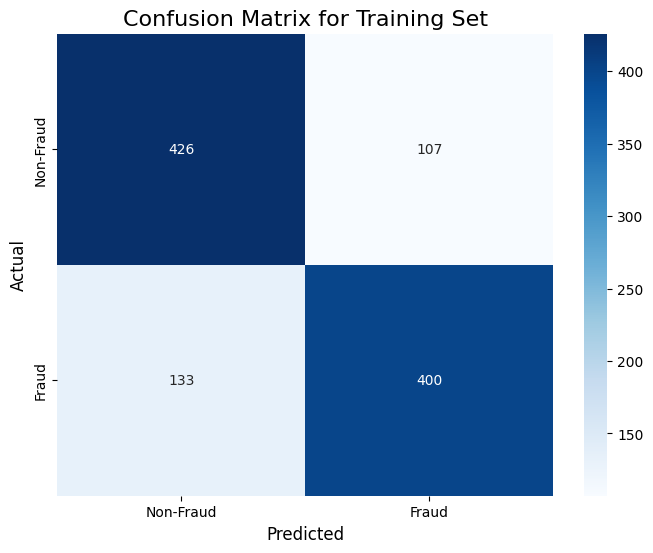

Classification Report (Training Set):

              precision    recall  f1-score   support

   Non-Fraud       0.76      0.80      0.78       533
       Fraud       0.79      0.75      0.77       533

    accuracy                           0.77      1066
   macro avg       0.78      0.77      0.77      1066
weighted avg       0.78      0.77      0.77      1066



In [50]:
# Generate predicted probabilities for the training set
probs_train = rf_final.predict_proba(X_train_resampled)[:, 1]  # Use resampled training data

# Apply custom threshold to classify predictions
threshold = 0.5
predictions_train = (probs_train >= threshold).astype(int)

# Generate the confusion matrix
cm_train = confusion_matrix(y_train_resampled, predictions_train)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix for Training Set", fontsize=16)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.show()

# Print the classification report
print("Classification Report (Training Set):\n")
print(classification_report(y_train_resampled, predictions_train, target_names=["Non-Fraud", "Fraud"]))


# Building the XGBoost (Without SMOTE) - Best

In [68]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Convert data into DMatrix format for training set
dtrain = xgb.DMatrix(X_train, label=y_train)

def objective(trial):
    # Define hyperparameter search space
    params = {
        'objective': 'binary:logistic',  # Binary classification objective
        'eval_metric': 'logloss',        # Logloss for early stopping
        'learning_rate': trial.suggest_float('eta', 0.01, 0.8),  # Learning rate (eta)
        'max_depth': trial.suggest_int('max_depth', 2, 5),       # Maximum depth of trees
        'subsample': trial.suggest_float('subsample', 0.2, 0.4),   # Subsampling ratio
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 0.6),  # Feature subsampling
        'reg_alpha': trial.suggest_float('reg_alpha', 0.4, 3),      # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0.4, 3),    # L2 regularization
        'gamma': trial.suggest_float('gamma', 0.1, 0.4),              # Minimum loss reduction required to make a further partition
        'seed': 42,                                           # Random seed for reproducibility
    }

    # 3-fold stratified cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    total_true_positives = 0

    # Perform cross-validation
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Convert the current fold into DMatrix format
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold)

        # Train the model
        num_boost_round = trial.suggest_int('n_estimators', 30, 100)  # Use this for num_boost_round

        model = xgb.train(
            params=params,
            dtrain=dtrain_fold,
            num_boost_round=num_boost_round,  # Use num_boost_round instead of n_estimators
            early_stopping_rounds=15,  # Stop early if validation loss doesn't improve
            evals=[(dval_fold, 'eval')],
            verbose_eval=False
        )

        # Predict on the validation fold
        y_pred_prob = model.predict(dval_fold)

        # Convert probabilities to binary predictions
        y_pred = (y_pred_prob >= 0.5).astype(int)

        # Calculate true positives
        true_positives = ((y_pred == 1) & (y_val_fold == 1)).sum()
        total_true_positives += true_positives

    # Return the total count of true positives across all folds
    return total_true_positives

# Optuna optimization
study = optuna.create_study(direction='maximize')  # Maximize the total true positives
study.optimize(objective, n_trials=50)

[I 2024-12-01 11:14:39,695] A new study created in memory with name: no-name-c09cde21-52da-4a1a-ac91-7309fa6935a3
[I 2024-12-01 11:14:41,839] Trial 0 finished with value: 17.0 and parameters: {'eta': 0.6089944183687431, 'max_depth': 4, 'subsample': 0.2886014455685843, 'colsample_bytree': 0.43755733692900617, 'reg_alpha': 1.828959097725889, 'reg_lambda': 0.972827603326511, 'gamma': 0.1657565314834346, 'n_estimators': 79}. Best is trial 0 with value: 17.0.
[I 2024-12-01 11:14:43,477] Trial 1 finished with value: 3.0 and parameters: {'eta': 0.3514791498908538, 'max_depth': 4, 'subsample': 0.38863553247979965, 'colsample_bytree': 0.29961593003270554, 'reg_alpha': 1.9027304982073003, 'reg_lambda': 0.5149255547526659, 'gamma': 0.12396039316723187, 'n_estimators': 73}. Best is trial 0 with value: 17.0.
[I 2024-12-01 11:14:44,678] Trial 2 finished with value: 3.0 and parameters: {'eta': 0.3780867075240416, 'max_depth': 2, 'subsample': 0.2137653498183315, 'colsample_bytree': 0.2398836479263543,

In [69]:
# Best hyperparameters
print("Best parameters:", study.best_params)
print("Best true positives:", study.best_value)

Best parameters: {'eta': 0.7923583596498492, 'max_depth': 4, 'subsample': 0.2631767608651752, 'colsample_bytree': 0.3267755190400322, 'reg_alpha': 1.7126611656542636, 'reg_lambda': 2.3687704604709894, 'gamma': 0.3562300635654809, 'n_estimators': 78}
Best true positives: 22.0


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[11:15:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




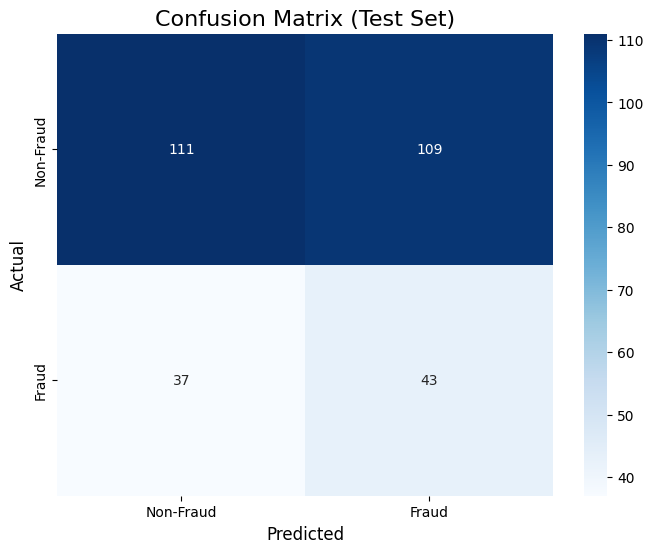

Classification Report (Test Set):

              precision    recall  f1-score   support

           0       0.75      0.50      0.60       220
           1       0.28      0.54      0.37        80

    accuracy                           0.51       300
   macro avg       0.52      0.52      0.49       300
weighted avg       0.63      0.51      0.54       300



In [71]:
# Train the final model using the best parameters on the full training set (X_train, y_train)
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=best_params['eta'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    gamma=best_params['gamma'],
    random_state=42,
    use_label_encoder=False  # Avoid warning related to label encoder
)

# Train the final model on the full training data
final_model.fit(X_train, y_train)

# Predict on the test set
probs_test = final_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
threshold = 0.2
y_pred = (probs_test >= threshold).astype(int)

# Confusion Matrix for Test Set
cm1 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix (Test Set)", fontsize=16)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.show()

# Classification Report for Test Set
print("Classification Report (Test Set):\n")
print(classification_report(y_test, y_pred))

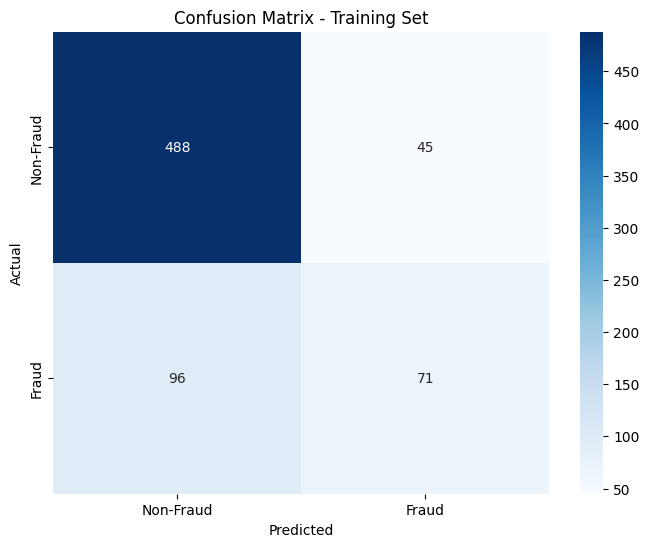

Classification Report - Training Set:
              precision    recall  f1-score   support

           0       0.84      0.92      0.87       533
           1       0.61      0.43      0.50       167

    accuracy                           0.80       700
   macro avg       0.72      0.67      0.69       700
weighted avg       0.78      0.80      0.79       700



In [59]:
y_pred_prob_train = final_model.predict(X_train)

y_pred_train = (y_pred_prob_train >= 0.5).astype(int)


# Confusion matrix for the training set
cm_train = confusion_matrix(y_train, y_pred_train)

# Plot confusion matrix using seaborn heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report for the training set
print("Classification Report - Training Set:")
print(classification_report(y_train, y_pred_train))

# Building the XGBoost (With SMOTE) - Best

In [85]:
dtrain = xgb.DMatrix(X_train, label=y_train)

import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE  # Import SMOTE

# Convert data into DMatrix format for training set
dtrain = xgb.DMatrix(X_train, label=y_train)

def objective(trial):
    # Define hyperparameter search space
    params = {
        'objective': 'binary:logistic',  # Binary classification objective
        'eval_metric': 'logloss',        # Logloss for early stopping
        'learning_rate': trial.suggest_float('eta', 0.01, 0.2),  # Learning rate (eta)
        'max_depth': trial.suggest_int('max_depth', 3, 7),       # Maximum depth of trees
        'subsample': trial.suggest_float('subsample', 0.7, 1),   # Subsampling ratio
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1),  # Feature subsampling
        'reg_alpha': trial.suggest_float('reg_alpha', 0.8, 2),      # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 2),    # L2 regularization
        'gamma': trial.suggest_float('gamma', 0.2, 0.5),              # Minimum loss reduction required to make a further partition
        'seed': 42,                                           # Random seed for reproducibility
    }

    # 3-fold stratified cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    total_true_positives = 0

    # Perform cross-validation
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Apply SMOTE to the training fold (only on the training data)
        smote = SMOTE(random_state=42)  # Initialize SMOTE
        X_train_fold_smote, y_train_fold_smote = smote.fit_resample(X_train_fold, y_train_fold)

        # Convert the current fold into DMatrix format
        dtrain_fold = xgb.DMatrix(X_train_fold_smote, label=y_train_fold_smote)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold)  # No SMOTE on validation fold

        # Train the model
        num_boost_round = trial.suggest_int('n_estimators', 30, 80)  # Use this for num_boost_round

        model = xgb.train(
            params=params,
            dtrain=dtrain_fold,
            num_boost_round=num_boost_round,  # Use num_boost_round instead of n_estimators
            early_stopping_rounds=15,  # Stop early if validation loss doesn't improve
            evals=[(dval_fold, 'eval')],
            verbose_eval=False
        )

        # Predict on the validation fold
        y_pred_prob = model.predict(dval_fold)

        # Convert probabilities to binary predictions
        y_pred = (y_pred_prob >= 0.5).astype(int)

        # Calculate true positives
        true_positives = ((y_pred == 1) & (y_val_fold == 1)).sum()
        total_true_positives += true_positives

    # Return the total count of true positives across all folds
    return total_true_positives

# Optuna optimization
study = optuna.create_study(direction='maximize')  # Maximize the total true positives
study.optimize(objective, n_trials=50)

[I 2024-12-01 13:11:05,676] A new study created in memory with name: no-name-e0c6a9da-97c4-4ef8-ad88-96dd794aeef2
[I 2024-12-01 13:11:09,924] Trial 0 finished with value: 15.0 and parameters: {'eta': 0.032241984860865956, 'max_depth': 6, 'subsample': 0.7323888179685584, 'colsample_bytree': 0.9397564604990506, 'reg_alpha': 1.3222167858100453, 'reg_lambda': 1.3419369551779583, 'gamma': 0.21576712246156868, 'n_estimators': 63}. Best is trial 0 with value: 15.0.
[I 2024-12-01 13:11:10,446] Trial 1 finished with value: 28.0 and parameters: {'eta': 0.12860619984014973, 'max_depth': 7, 'subsample': 0.7974899569688035, 'colsample_bytree': 0.6636595088975, 'reg_alpha': 1.0513210421318715, 'reg_lambda': 1.6115035902414576, 'gamma': 0.3519314329680886, 'n_estimators': 42}. Best is trial 1 with value: 28.0.
[I 2024-12-01 13:11:10,951] Trial 2 finished with value: 18.0 and parameters: {'eta': 0.17280769632301055, 'max_depth': 5, 'subsample': 0.8757914709100147, 'colsample_bytree': 0.812315500873001

In [86]:
# Best hyperparameters
print("Best parameters:", study.best_params)
print("Best true positives:", study.best_value)

Best parameters: {'eta': 0.1410805988971588, 'max_depth': 6, 'subsample': 0.7949300721962038, 'colsample_bytree': 0.6637357698937776, 'reg_alpha': 1.2151070056020385, 'reg_lambda': 1.7321998169303496, 'gamma': 0.3430291708938972, 'n_estimators': 67}
Best true positives: 30.0


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[13:12:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




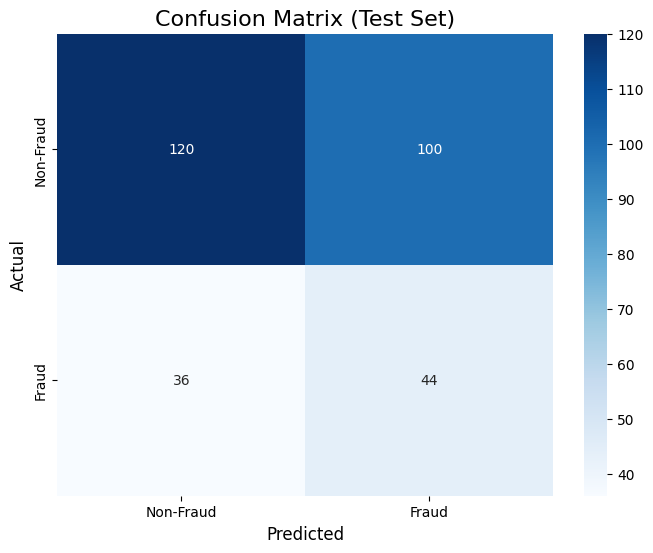

Classification Report (Test Set):

              precision    recall  f1-score   support

           0       0.77      0.55      0.64       220
           1       0.31      0.55      0.39        80

    accuracy                           0.55       300
   macro avg       0.54      0.55      0.52       300
weighted avg       0.65      0.55      0.57       300



In [89]:
# Train the final model using the best parameters on the full training set (X_train, y_train)
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=best_params['eta'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    gamma=best_params['gamma'],
    random_state=42,
    use_label_encoder=False  # Avoid warning related to label encoder
)

# Apply SMOTE to the full training data before fitting the final model
smote = SMOTE(random_state=42)  # Initialize SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)  # Apply SMOTE to training set only

# Train the final model on the resampled data
final_model.fit(X_train_smote, y_train_smote)

# Predict on the test set
probs_test = final_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
threshold = 0.27
y_pred = (probs_test >= threshold).astype(int)

# Confusion Matrix for Test Set
cm1 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix (Test Set)", fontsize=16)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.show()

# Classification Report for Test Set
print("Classification Report (Test Set):\n")
print(classification_report(y_test, y_pred))

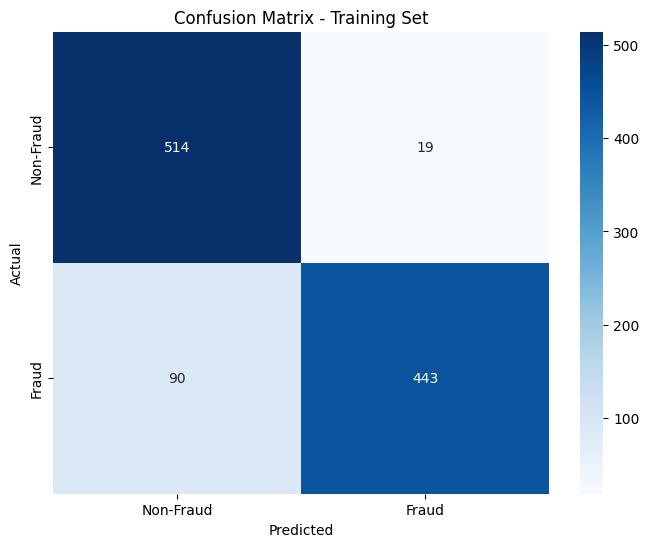

Classification Report - Training Set:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       533
           1       0.96      0.83      0.89       533

    accuracy                           0.90      1066
   macro avg       0.90      0.90      0.90      1066
weighted avg       0.90      0.90      0.90      1066



In [55]:
# Predict on the training set
y_pred_prob_train = final_model.predict(X_train_smote)
final_threshold = 0.5
y_pred_train = (y_pred_prob_train >= final_threshold).astype(int)

# Confusion matrix for the training set
cm_train = confusion_matrix(y_train_smote, y_pred_train)

# Plot confusion matrix using seaborn heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report for the training set
print("Classification Report - Training Set:")
print(classification_report(y_train_smote, y_pred_train))